In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

# Load libraries and set device engine

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


# Load Dataset and split data

In [3]:
def load_calhous_dataset():
    # Load California housing dataset
    calhous = fetch_california_housing()
    data = calhous.data
    target = calhous.target

    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.1, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    train_inputs = torch.empty(0, data_tensor.size(1), device=device)
    train_labels = torch.empty(0, dtype=torch.float32, device=device)
    test_inputs = torch.empty(0, data_tensor.size(1), device=device)
    test_labels = torch.empty(0, dtype=torch.float32, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in tqdm(train_loader):
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in tqdm(test_loader):
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels.reshape(-1, 1)
    dataset['test_label'] = test_labels.reshape(-1, 1)

    return dataset

dataset = load_calhous_dataset()

100%|██████████| 2064/2064 [00:01<00:00, 1726.74it/s]


In [4]:
#input_vars = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']
input_vars = ['MI','HA','AR','AB','P','AO','La','Lo']

In [5]:
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([18576, 8])
Train target shape: torch.Size([18576, 1])
Test data shape: torch.Size([2064, 8])
Test target shape: torch.Size([2064, 1])


# Create Kan Network

In [6]:
# 8 inputs, 3 hidden, 1 output
model = KAN(width=[8, 12, 1], grid=12, k=3, seed=0, device=device)

checkpoint directory created: ./model
saving model version 0.0


# Train dataset

In [7]:
results = model.fit(dataset, opt="Adam", steps=60, lamb=0.001, lamb_entropy=.01)

| train_loss: 1.14e+00 | test_loss: 1.07e+00 | reg: 6.50e+02 | : 100%|█| 60/60 [00:10<00:00,  5.72it

saving model version 0.1


In [8]:
results = model.fit(dataset, opt="LBFGS", steps=60, lamb=0.001, lamb_entropy=.01)

| train_loss: 4.78e-01 | test_loss: 5.12e-01 | reg: 7.43e+01 | : 100%|█| 60/60 [01:34<00:00,  1.58s/

saving model version 0.2


In [122]:
results = model.fit(dataset, opt="LBFGS", steps=60, lamb=0.001, lamb_entropy=.01, reg_metric='edge_forward_spline_n')

| train_loss: 4.48e-01 | test_loss: 4.85e-01 | reg: 1.62e+01 | : 100%|█| 60/60 [00:21<00:00,  2.83it

saving model version 0.1


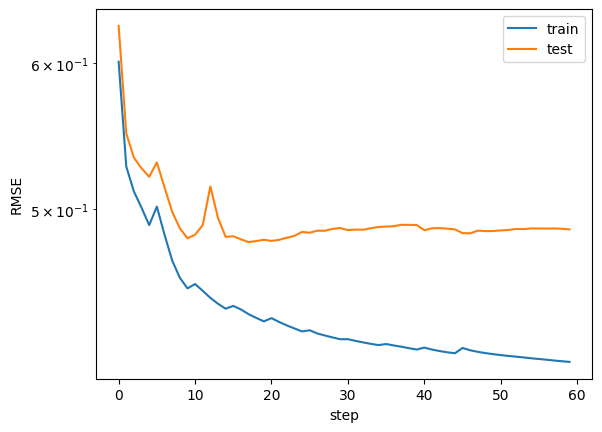

In [8]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

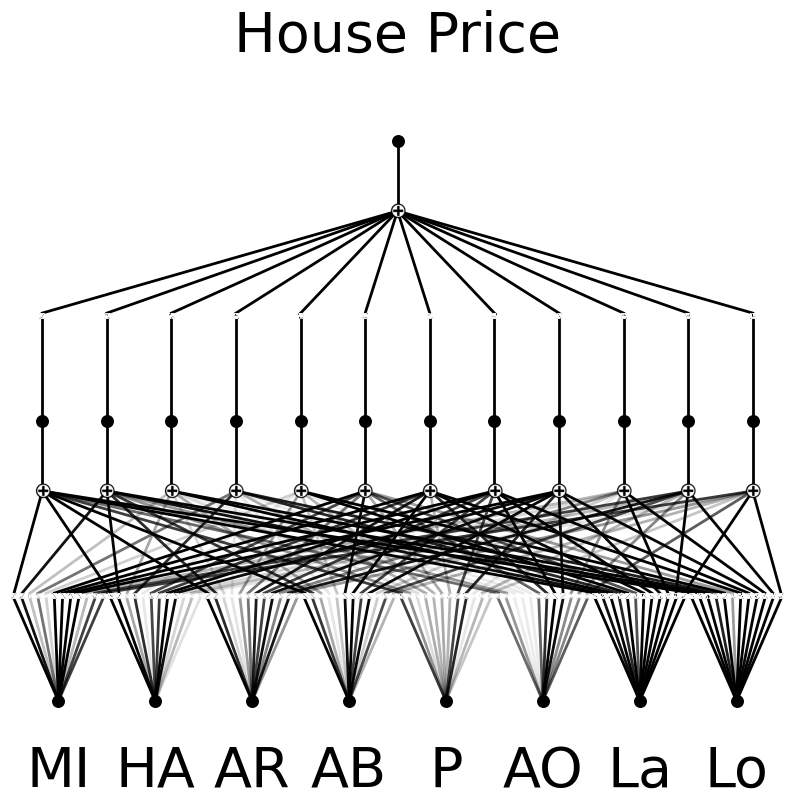

In [124]:
model.plot(beta=50, scale=1,in_vars=input_vars, out_vars=['House Price'])

# Show symbolic formula generated

In [125]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.9765904545783997, c=1
fixing (0,0,1) with x, r2=0.680465817451477, c=1
fixing (0,0,2) with x, r2=0.30162280797958374, c=1
fixing (0,0,3) with x, r2=0.7910828590393066, c=1
fixing (0,0,4) with x, r2=0.7882108688354492, c=1
fixing (0,0,5) with x, r2=0.9033933877944946, c=1
fixing (0,0,6) with x, r2=0.8512812852859497, c=1
fixing (0,0,7) with sin, r2=0.9786099195480347, c=2
fixing (0,0,8) with x, r2=0.7940358519554138, c=1
fixing (0,0,9) with x, r2=0.8807955384254456, c=1
fixing (0,0,10) with sin, r2=0.9662820100784302, c=2
fixing (0,0,11) with x, r2=0.9679688811302185, c=1
fixing (0,1,0) with x, r2=0.8030456900596619, c=1
fixing (0,1,1) with x, r2=0.8620676398277283, c=1
fixing (0,1,2) with x, r2=0.8049867153167725, c=1
fixing (0,1,3) with x, r2=0.8315892219543457, c=1
fixing (0,1,4) with sin, r2=0.9514980912208557, c=2
fixing (0,1,5) with x, r2=0.1296408772468567, c=1
fixing (0,1,6) with x, r2=0.36357271671295166, c=1
fixing (0,1,7) with x, r2=0.8230635523796

0.3431*x_1 - 0.0797*x_2 + 0.2743*x_3 - 0.0964*x_4 - 0.003*x_5 - 0.0562*x_6 - 0.5932*x_7 - 0.4589*x_8 - 0.0356*sin(0.5831*x_1 + 7.0167) - 0.0015*sin(1.7178*x_2 - 1.7947) + 0.0006*sin(1.8226*x_6 + 1.8284) + 0.0428*sin(2.6116*x_6 - 1.4098) + 0.0018*sin(2.6193*x_6 + 1.5833) + 0.0642*sin(2.994*x_6 - 7.5881) - 0.1204*sin(3.3682*x_6 + 4.9941) + 0.0067*sin(3.405*x_6 - 7.5914) + 0.0204*sin(3.9885*x_6 + 5.0028) + 0.0742*sin(5.0002*x_6 + 5.0027) + 1.715

# Show Feature Importance

In [126]:
model.feature_score

tensor([0.7730, 0.3418, 0.4180, 0.3838, 0.1135, 0.5291, 1.6611, 1.4451],
       device='cuda:0', grad_fn=<MeanBackward1>)

# Notes
03/05
- I tried many combination in order to achieve the best test_loss:
- This was the best model = KAN(width=[8, 12, 1], grid=8, k=3, seed=0, device=device)
- With this fit results = model.fit(dataset, opt="LBFGS", steps=60, lamb=0.001, lamb_entropy=.01, reg_metric='edge_forward_spline_n')
- With opt='Adam' the results were really bad
- During the testing I tried bigger lamb [0.01, 0.1] and performance decreased
- Increasing the lamb_entropy > 1 perform bad
- In middle layer low and greater than 12 perform bad but maybe we must continue working on that

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 20
    best_model = None
    best_epoch = 0
    warm_up_epochs = epochs*0.3

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, targets in train_loader:
            num_data, targets = num_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data,  targets in val_loader:
                num_data, targets = num_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)

                outputs = model(num_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            #early_stopping_counter = 0
        #else:
            #if epoch > warm_up_epochs:
                #early_stopping_counter += 1
                #if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered at epoch {epoch+1}")
                    #break

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save figures for this fold
    os.makedirs(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}", exist_ok=True)
    plot_metric(history['train_loss'], history['val_loss'], 'Loss', dataset_name, model_name)
    plot_metric(history['train_mse'], history['val_mse'], 'MSE', dataset_name, model_name)
    plot_metric(history['train_rmse'], history['val_rmse'], 'RMSE', dataset_name, model_name)
    plot_learning_rate(history['learning_rate'], dataset_name, model_name)

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/CNN+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/CNN+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')    

    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, targets in data_loader:
            num_data, targets = num_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            outputs = model(num_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }    

def plot_metric(train_metric, val_metric, metric_name, dataset_name, model_name):
    plt.figure()
    plt.plot(train_metric, label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/{metric_name.lower()}_plot.png")
    plt.close()

def plot_learning_rate(learning_rates, dataset_name, model_name):
    plt.figure()
    plt.plot(learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/learning_rate_plot.png")
    plt.close()

In [ ]:
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=2e-4, max_lr=1e-2)  # Train and evaluate Model1

In [ ]:
dataset['train_input'] = train_inputs
dataset['test_input'] = test_inputs
dataset['train_label'] = train_labels.reshape(-1, 1)
dataset['test_label'] = test_labels.reshape(-1, 1)